# Exploration of water and weather data 

#### Key points
1. Trend through time (month, day, day)
2. Minimum and maximum of consumption per time frame
3. Correlations between variables:
      - Consumption vs. time of year
      - Consumptions vs. weather 

## 1. Trend analysis - date and time

In [44]:
# Import libraries for plotting, reading and wrangling data
library(ggplot2)
library(cowplot)
library(gridExtra)
library(readr) 
library(dplyr)
library(tidyr)
library(tibble)
library(grid)
library(stringr)
source("../../Common/func.R")

### Read Data Frames

In [45]:
# Read dayly, daily and monthly water consumption data in csv files
ConsHourDF  <- read_csv("../../../curated/water/gold_hourly_water.csv",     show_col_types = FALSE)
ConsDayDF   <- read_csv("../../../curated/water/gold_daily_water.csv",      show_col_types = FALSE)
# Remove last month since it's not a  complete month. This would impact the mean and min max values
ConsMonthDF <- read_csv("../../../curated/water/gold_monthly_water.csv",    show_col_types = FALSE) %>%
    mutate(
        month_str = ifelse(nchar(month) == 1, paste0("0", as.character(month)), as.character(month)),
        year_month = factor(paste(year, month_str, sep = "-"))
    ) %>% 
    filter(year_month != "2014-04") %>%
    select(-month_str)

### Global Variables

In [46]:
#==============================================
# HOUR
#==============================================
# Define average, minimal and maximal thresholds
avg_hour_consumption    <- mean(ConsHourDF$consumption)
min_hour_consumption    <- min(ConsHourDF$consumption)
max_hour_consumption    <- max(ConsHourDF$consumption)
pct05_hour_consumption  <- quantile(ConsHourDF$consumption, 0.05)
pct95_hour_consumption  <- quantile(ConsHourDF$consumption, 0.95)
# Define outliers columns: either below or above thresholds
ConsHourDF <- ConsHourDF %>% mutate(is_outlier = (consumption == min_hour_consumption) | (consumption == max_hour_consumption))

#==============================================
# DAY
#==============================================
# Define average, minimal and maximal thresholds
avg_day_consumption    <- mean(ConsDayDF$consumption)
min_day_consumption    <- min(ConsDayDF$consumption)
max_day_consumption    <- max(ConsDayDF$consumption)
pct05_day_consumption  <- quantile(ConsDayDF$consumption, 0.05)
pct95_day_consumption  <- quantile(ConsDayDF$consumption, 0.95)
# Define outliers columns: either below or above thresholds
ConsDayDF <- ConsDayDF %>% mutate(is_outlier = (consumption == min_day_consumption) | (consumption == max_day_consumption))

#==============================================
# DAY NUMBER
#==============================================
# Define filtered Data Frame for the plot labels
# maxConsDayDF <- ConsDayDF %>% group_by(day) %>% summarise(consumption = max(consumption))
# Aggregate data by day number
ConsDayNumDF <- ConsDayDF %>% group_by(day) %>% summarize(consumption = round(mean(consumption), 2))
# Define average, minimal and maximal thresholds
avg_day_num_consumption     <- mean(ConsDayNumDF$consumption)
min_day_num_consumption     <- min(ConsDayNumDF$consumption)
max_day_num_consumption     <- max(ConsDayNumDF$consumption)
pct05_day_num_consumption   <- quantile(ConsDayNumDF$consumption, 0.05)
pct95_day_num_consumption   <- quantile(ConsDayNumDF$consumption, 0.95)
# Threshold: 95%
ConsDayNumDF <- ConsDayNumDF %>% mutate(is_outlier = (consumption == min_day_num_consumption) | (consumption == max_day_num_consumption))

#==============================================
# MONTH
#==============================================
# Define average, minimal and maximal thresholds
# Remove data from month: 2014-04 since it is not complete and is not a real outlier
avg_month_consumption   <- as.double(ConsMonthDF %>% summarise(mean = round(mean(consumption), 2)))
min_month_consumption   <- as.double(ConsMonthDF %>% summarise(min = round(min(consumption), 2)))
max_month_consumption   <- as.double(ConsMonthDF %>% summarise(max = round(max(consumption), 2)))
pct05_month_consumption <- as.double(ConsMonthDF %>% summarise(pct05 = round(quantile(consumption, 0.05), 2)))
pct95_month_consumption <- as.double(ConsMonthDF %>% summarise(pct95 = round(quantile(consumption, 0.95), 2)))
# Define outliers columns: either below or above thresholds
ConsMonthDF <- ConsMonthDF %>% mutate(is_outlier = (consumption == min_month_consumption) | (consumption == max_month_consumption))

### a) Daily and hourly consumption

#### Plot 1: Line plot - Four weeks comparison

##### Prepare Data Frames for line plot

In [47]:
# Date parameters
# The year and month have been selected randomly
year <- 2013
month <- 01

# Calculate four weeks dataframes
ConsDayHourWeekOneDF    <- ConsHourDF %>% filter_date_range(year, month, 0, 7)      %>% create_instant_time()
ConsDayHourWeekTwoDF    <- ConsHourDF %>% filter_date_range(year, month, 7, 14)     %>% create_instant_time()
ConsDayHourWeekThreeDF  <- ConsHourDF %>% filter_date_range(year, month, 14, 21)    %>% create_instant_time()
ConsDayHourWeekFourDF   <- ConsHourDF %>% filter_date_range(year, month, 21, 28)    %>% create_instant_time()

##### Plot data

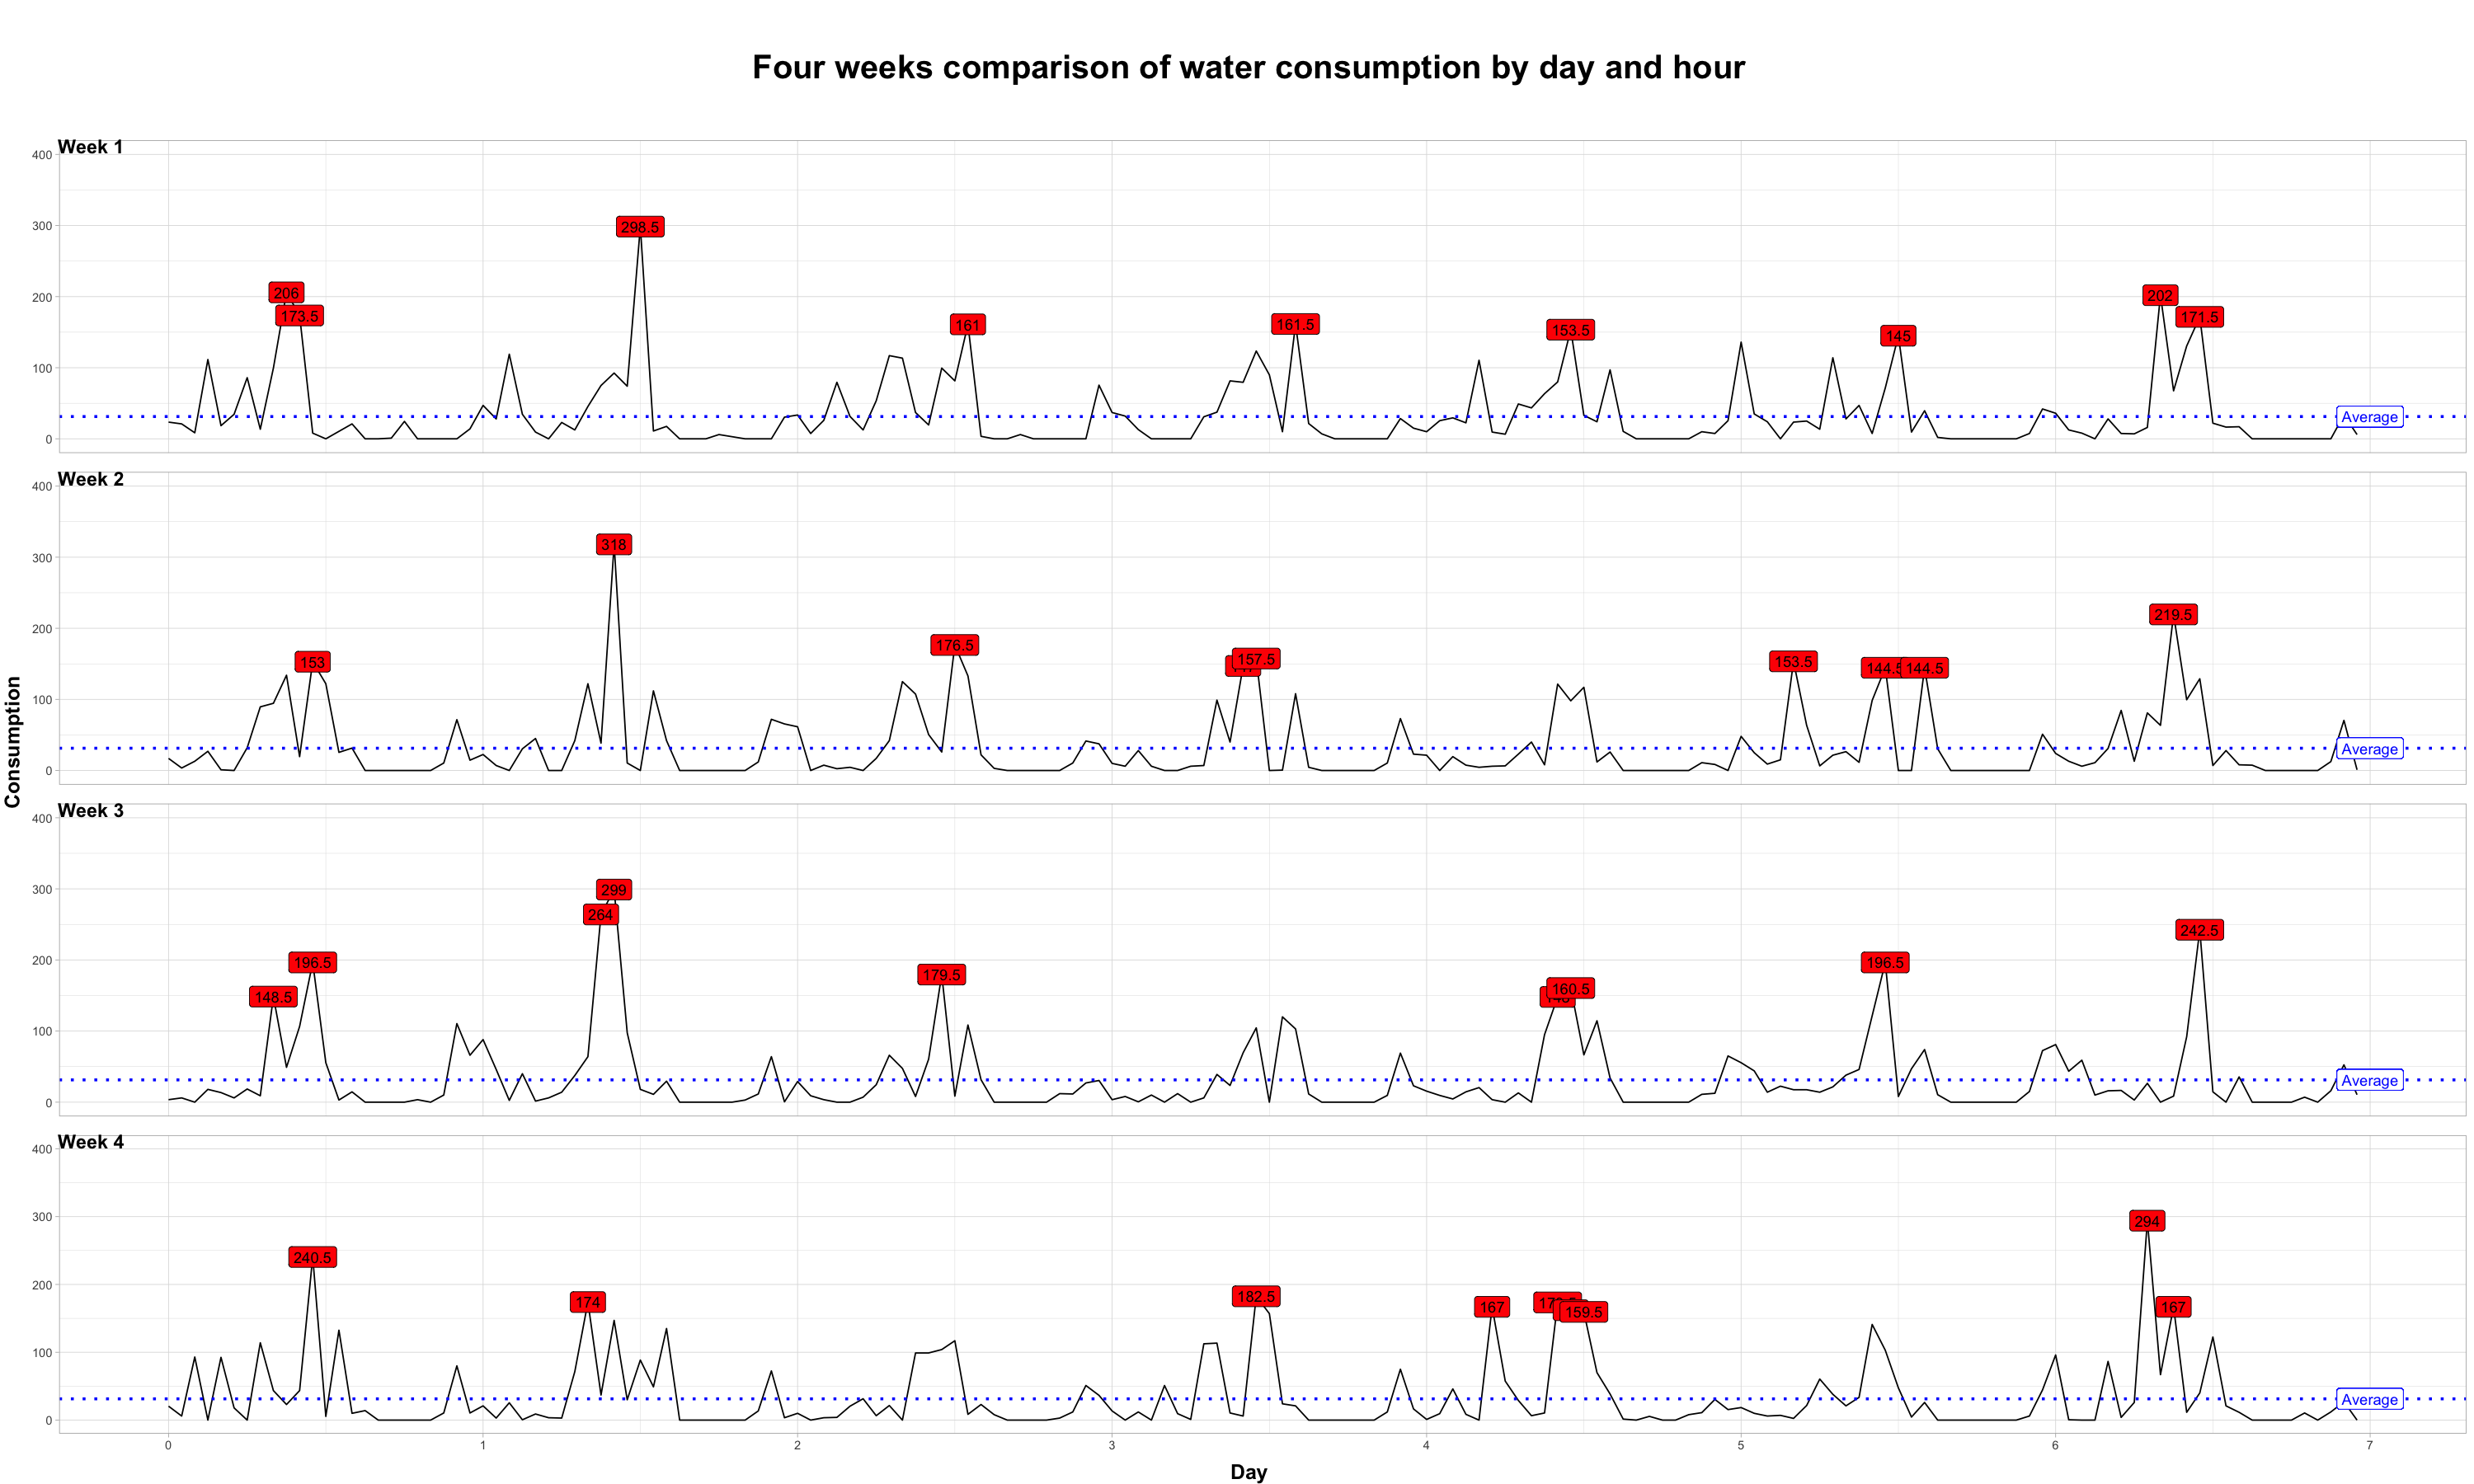

In [66]:
# Visualization of water consumption per day and hour
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 15)
# Plot labels definition
label_properties_list <- list("pct05_color"="black", "pct95_color"="black", "pct05_fill"="red", "pct95_fill"="red")
# Plot definitions
plt_wk1 <- create_base_weekly_line_plot(ConsDayHourWeekOneDF,   instant, consumption, label_properties_list, avg_hour_consumption, 0, 400)
plt_wk2 <- create_base_weekly_line_plot(ConsDayHourWeekTwoDF,   instant, consumption, label_properties_list, avg_hour_consumption, 0, 400)
plt_wk3 <- create_base_weekly_line_plot(ConsDayHourWeekThreeDF, instant, consumption, label_properties_list, avg_hour_consumption, 0, 400)
plt_wk4 <- create_base_weekly_line_plot(ConsDayHourWeekFourDF,  instant, consumption, label_properties_list, avg_hour_consumption, 0, 400, TRUE)

# Grid of plots definition
global_grid <- plot_grid(
    plt_wk1, plt_wk2, plt_wk3, plt_wk4,
    labels = c("Week 1", "Week 2", "Week 3", "Week 4"), label_y = 1,
    ncol = 1, nrow = 4
)

# Titles definition
title       <- ggdraw() + draw_label("Four weeks comparison of water consumption by day and hour", fontface = "bold", size = 24)
x_title     <- textGrob("Day", gp = gpar(fontface="bold", col="black", fontsize = 15))
y_title     <- textGrob("Consumption", gp = gpar(fontface="bold", col="black", fontsize = 15), rot=90)
plot        <- plot_grid(title, global_grid, ncol = 1, rel_heights = c(0.1, 1))

# Arrange the plot to have global x and y titles
grid.arrange(arrangeGrob(plot, bottom = x_title, left = y_title))

### b) Hourly consumption

#### Base plot and configuration

In [49]:
# Define basic plot
base_plt_hour           <- ggplot(ConsHourDF, aes(x = hour, y = consumption))
# Define horizontal plot for average consumption
base_hline_avg_hour     <- geom_hline(yintercept = avg_hour_consumption, color = "blue", linetype = "dotted", linewidth = 1)
# Define plot title
base_title_hour         <- ggtitle("Distribution of water consumption by hour")
# Define plot theme
base_theme_hour         <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )


#### Plot 2: Scatter plot with jitter - Consumption by hour

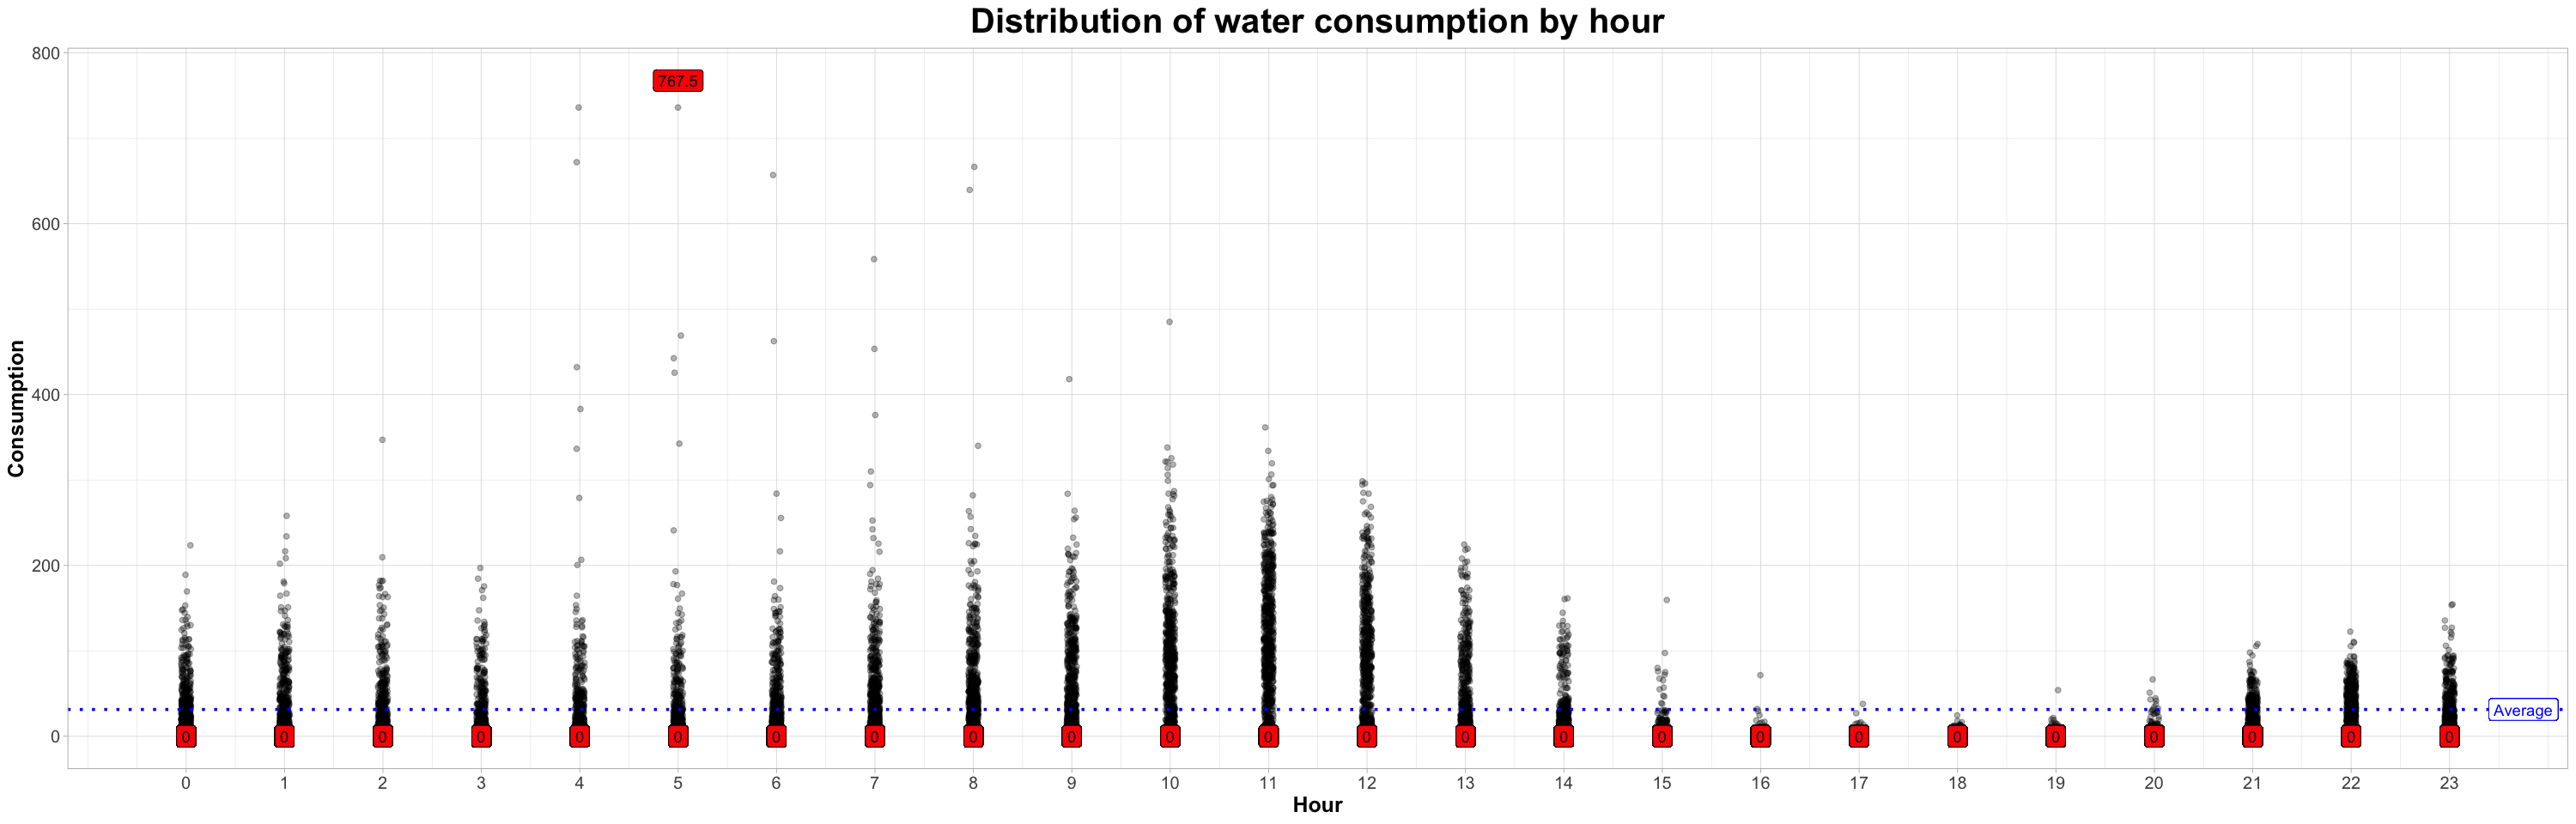

In [50]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define scatter plot
base_plt_hour + 
    geom_jitter(alpha = 0.3, width = 0.05) + 
    scale_x_continuous(breaks = 0:23, labels = 0:23) +
    base_hline_avg_hour +
    geom_label(label = "Average", x = 23.75, y = avg_hour_consumption, color = "blue") +
    geom_label(data = ConsHourDF %>% filter(is_outlier), aes(label = consumption), color = "black", fill = "red") +
    labs(x = "Hour", y = "Consumption") +
    base_title_hour +
    base_theme_hour

#### Plot 3: Boxplot - Distribution of consumption by hour

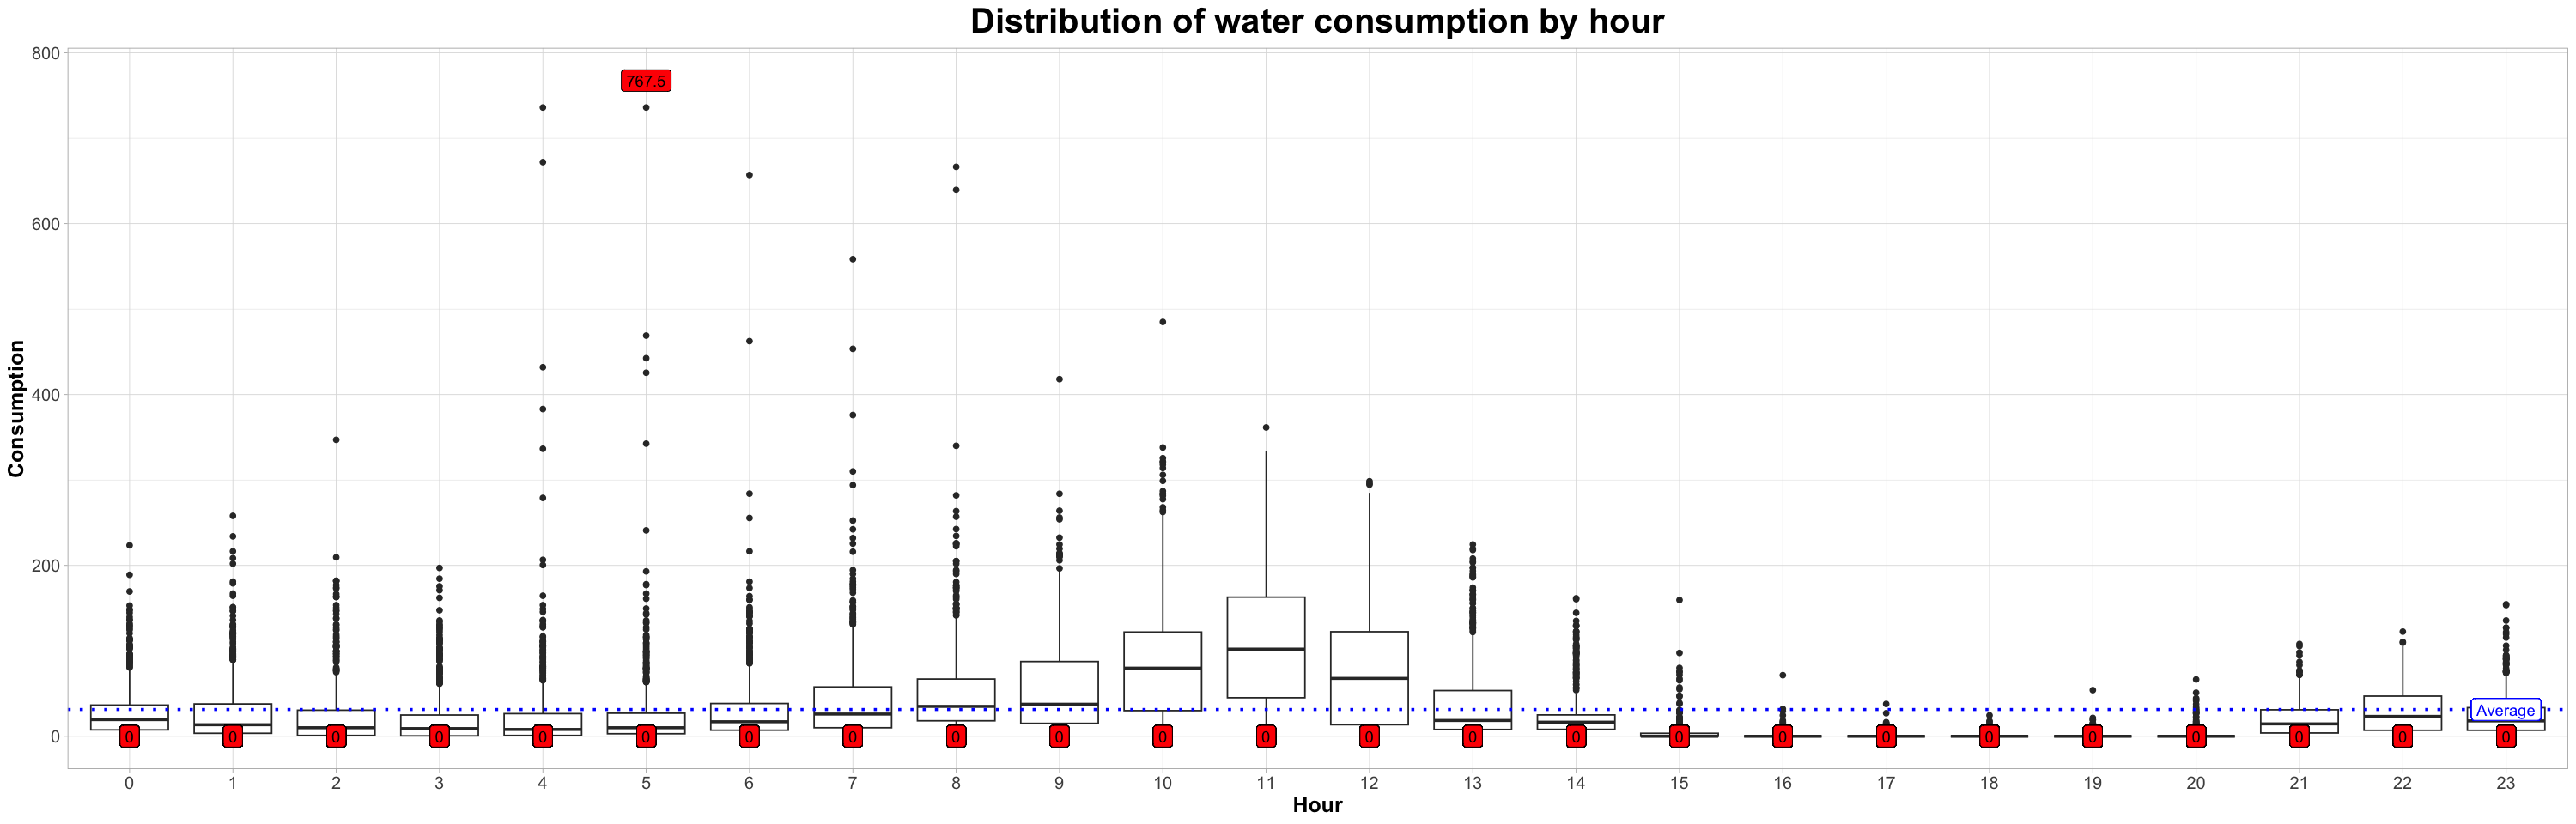

In [51]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define box plot
base_plt_hour + 
    geom_boxplot(aes(x = factor(hour))) + 
    base_hline_avg_hour +
    geom_label(label = "Average", x = 24, y = avg_hour_consumption, color = "blue") +
    geom_label(data = ConsHourDF %>% filter(is_outlier), aes(label = consumption), nudge_x = 1, color = "black", fill = "red") +
    labs(x = "Hour", y = "Consumption") +
    base_title_hour +
    base_theme_hour

### c) Daily consumption

#### Base plot and configuration

In [52]:
# Define basic plot
base_plt_day           <- ggplot(ConsDayDF, aes(x = day, y = consumption))
# Define horizontal plot for average consumption
base_hline_avg_day     <- geom_hline(yintercept = avg_day_consumption, color = "blue", linetype = "dotted", linewidth = 1)
# Define plot title
base_title_day         <- ggtitle("Distribution of water consumption by day")
# Define plot theme
base_theme_day         <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )

#### Plot 4: Boxplot - Distribution of consumption by day number

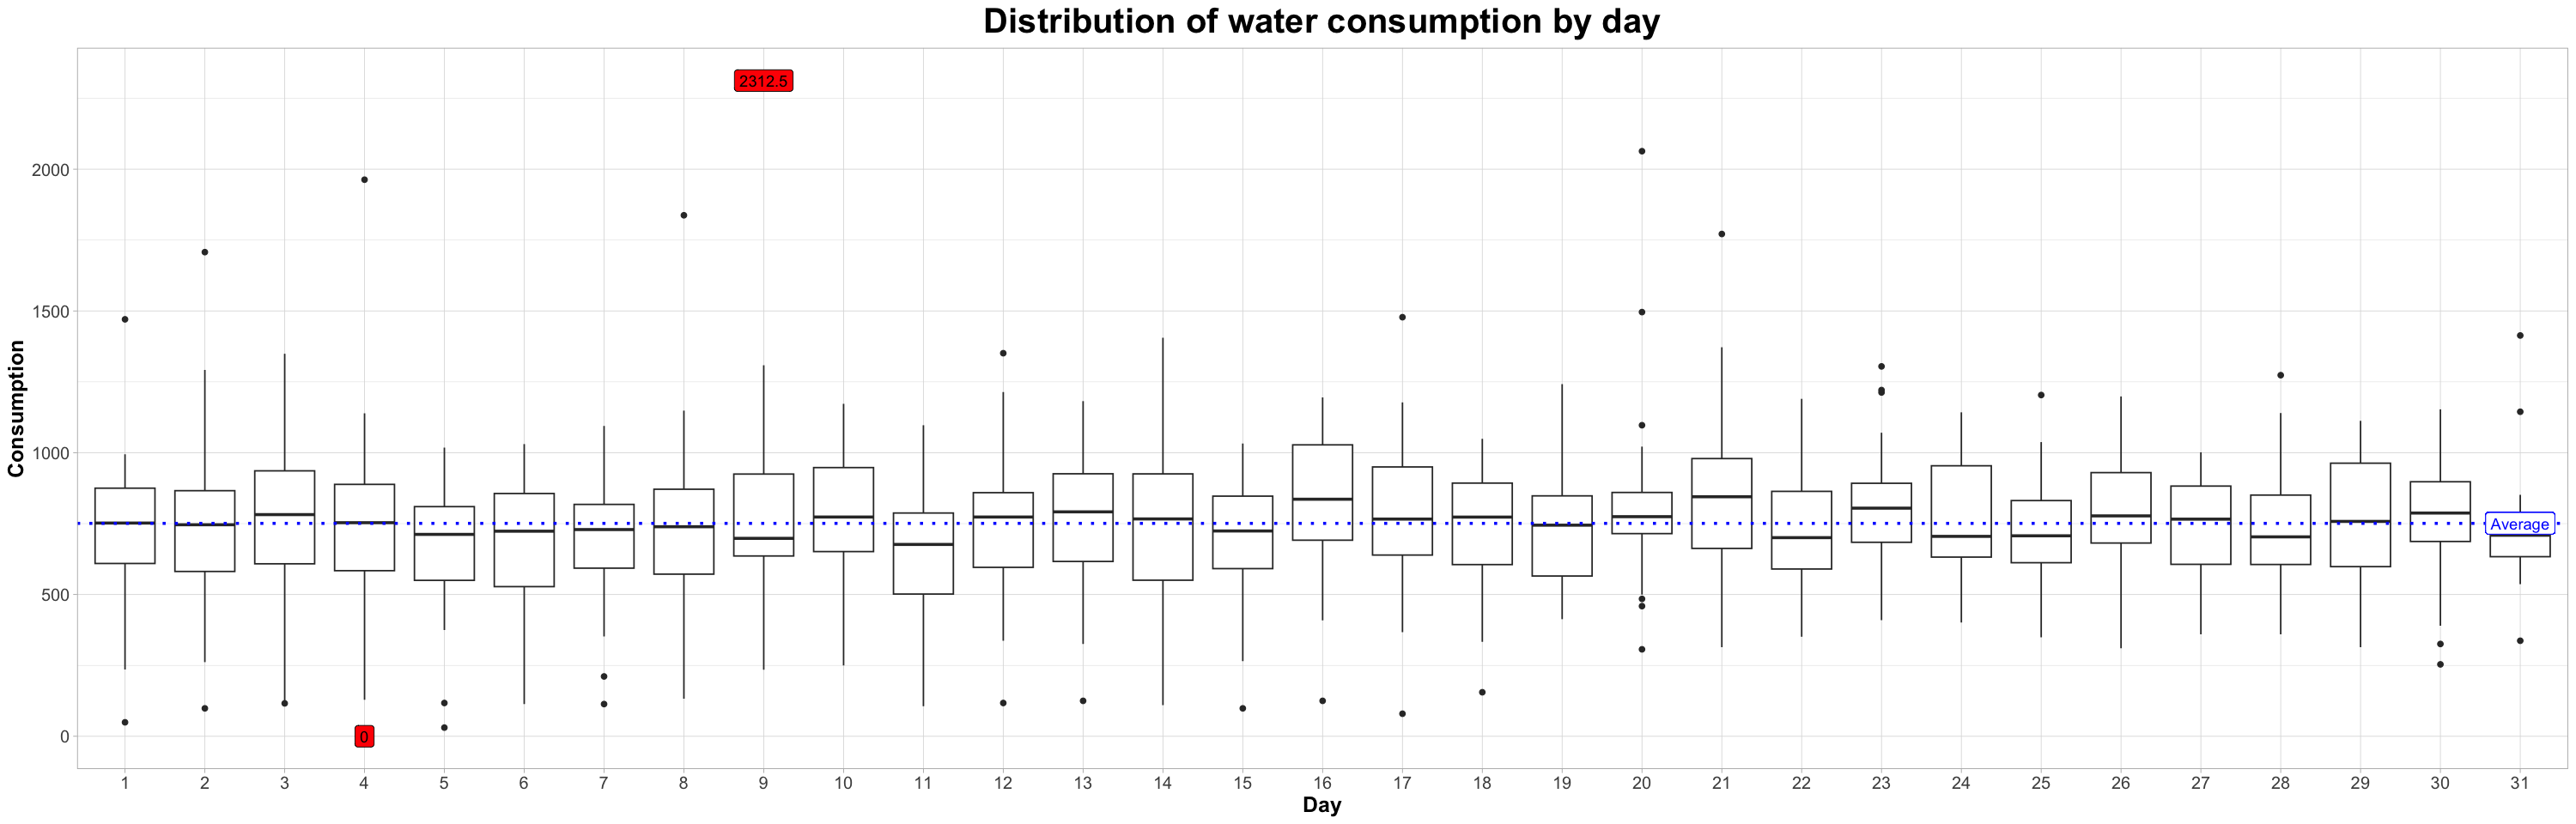

In [53]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_day +
    geom_boxplot(aes(x = factor(day))) +
    base_hline_avg_day +
    geom_label(label = "Average", x = 31, y = avg_day_consumption, color = "blue", show.legend = TRUE) +
    geom_label(data = ConsDayDF %>% filter(is_outlier), aes(label = consumption), color = "black", fill = "red") +
    labs(x = "Day", y = "Consumption") +
    base_title_day + 
    base_theme_day

#### Plot 5: Line plot - Consumption by day number

In [54]:
# Define basic plot
base_plt_day_num           <- ggplot(ConsDayNumDF, aes(x = day, y = consumption))
# Define horizontal plot for average consumption
base_hline_avg_day_num     <- geom_hline(yintercept = avg_day_num_consumption, color = "blue", linetype = "dotted", linewidth = 1)
# Define plot title
base_title_day_num         <- ggtitle("Average water consumption by day")
# Define plot theme
base_theme_day_num         <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


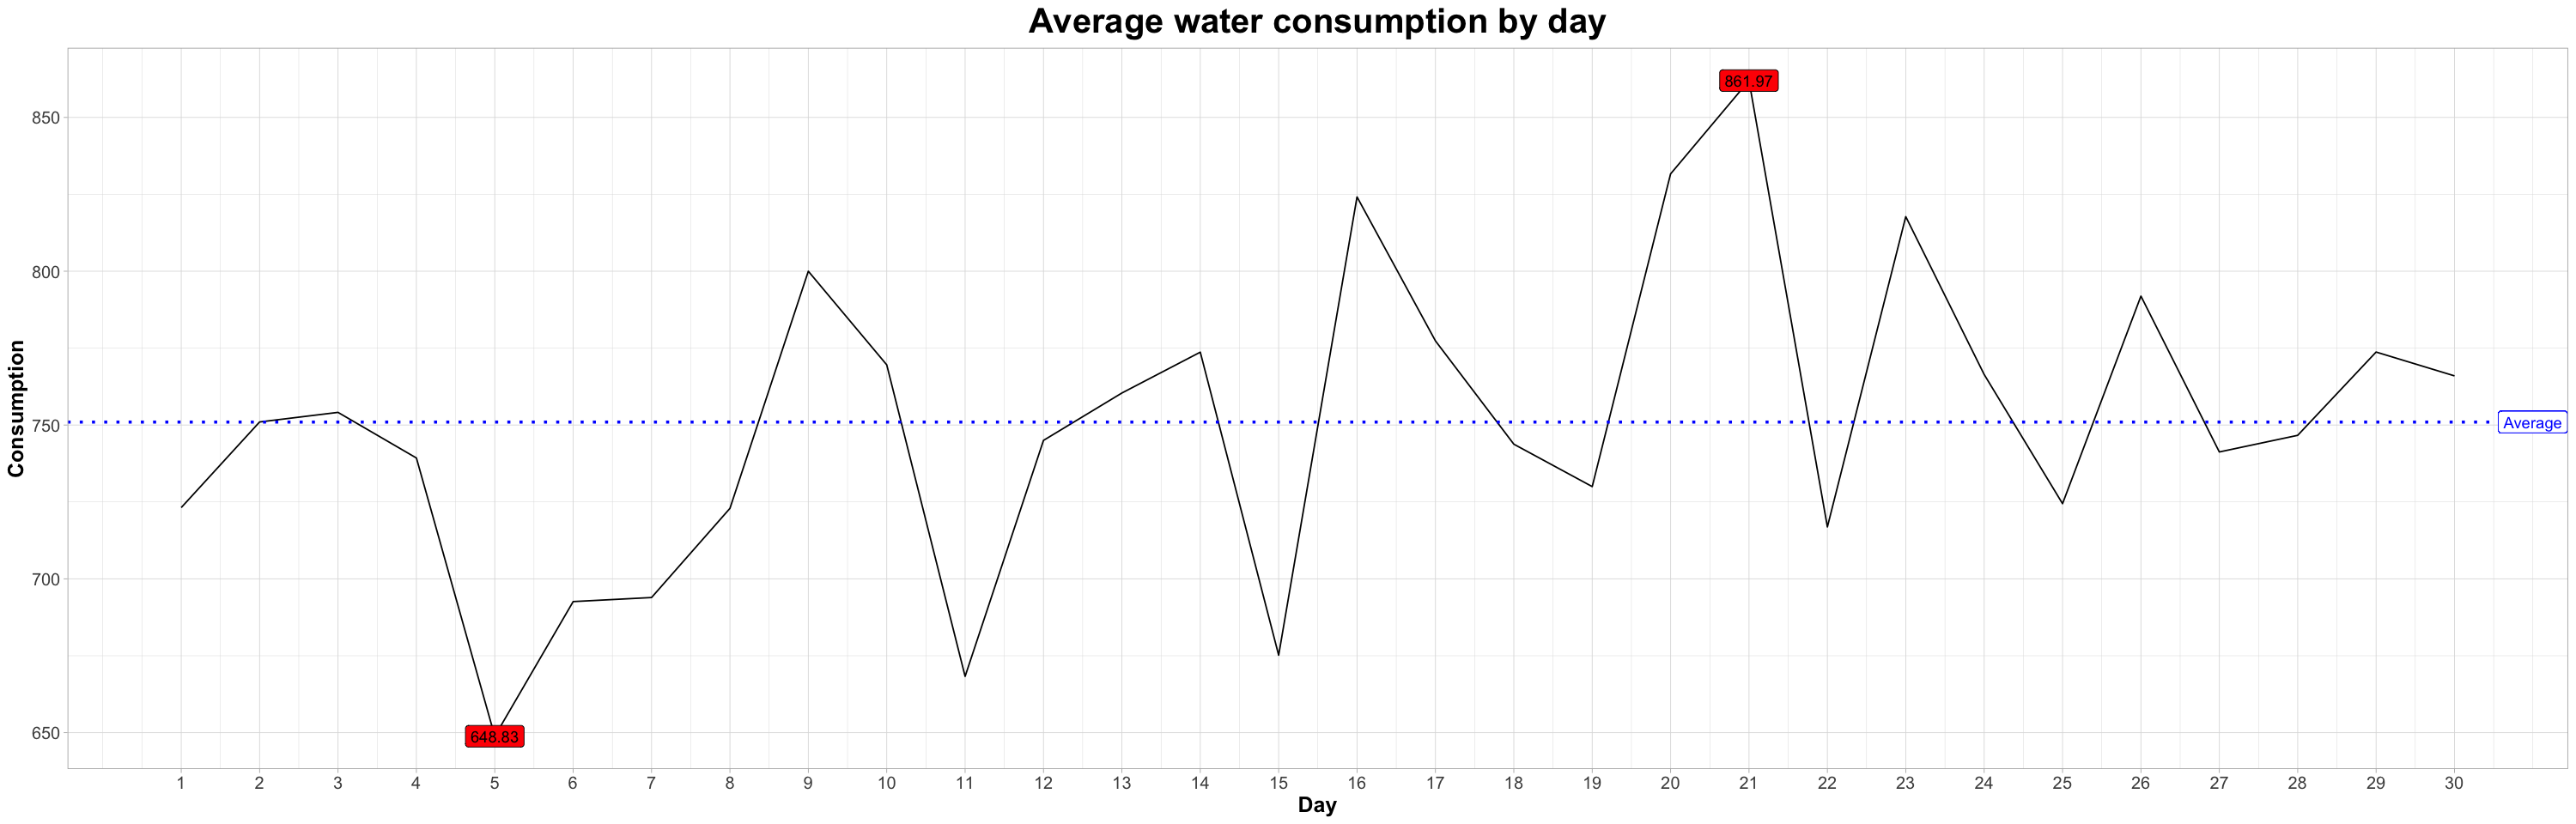

In [55]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_day_num +
    geom_line() +
    base_hline_avg_day_num +
    scale_x_continuous(breaks = 1:30, labels = 1:30, limits = c(1, 30)) +
    geom_label(label = "Average", x = 31, y = avg_day_num_consumption, color = "blue", show.legend = TRUE) +
    geom_label(data = ConsDayNumDF %>% filter(is_outlier), aes(label = consumption), color = "black", fill = "red") +
    labs(x = "Day", y = "Consumption") +
    base_title_day_num + 
    base_theme_day_num

### d) Monthly consumption

#### Base plot and configuration

In [56]:
# Define basic plot
base_plt_month          <- ggplot(ConsMonthDF, aes(x = month, y = consumption))
# Define horizontal plot for average consumption
base_hline_avg_month    <- geom_hline(yintercept = avg_month_consumption, color = "blue", linetype = "dotted", linewidth = 1)
# Define plot title
base_title_month        <- ggtitle("Distribution of water consumption by month")
# Define plot theme
base_theme_month        <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )

#### Plot 6: Boxplot - Consumption by month

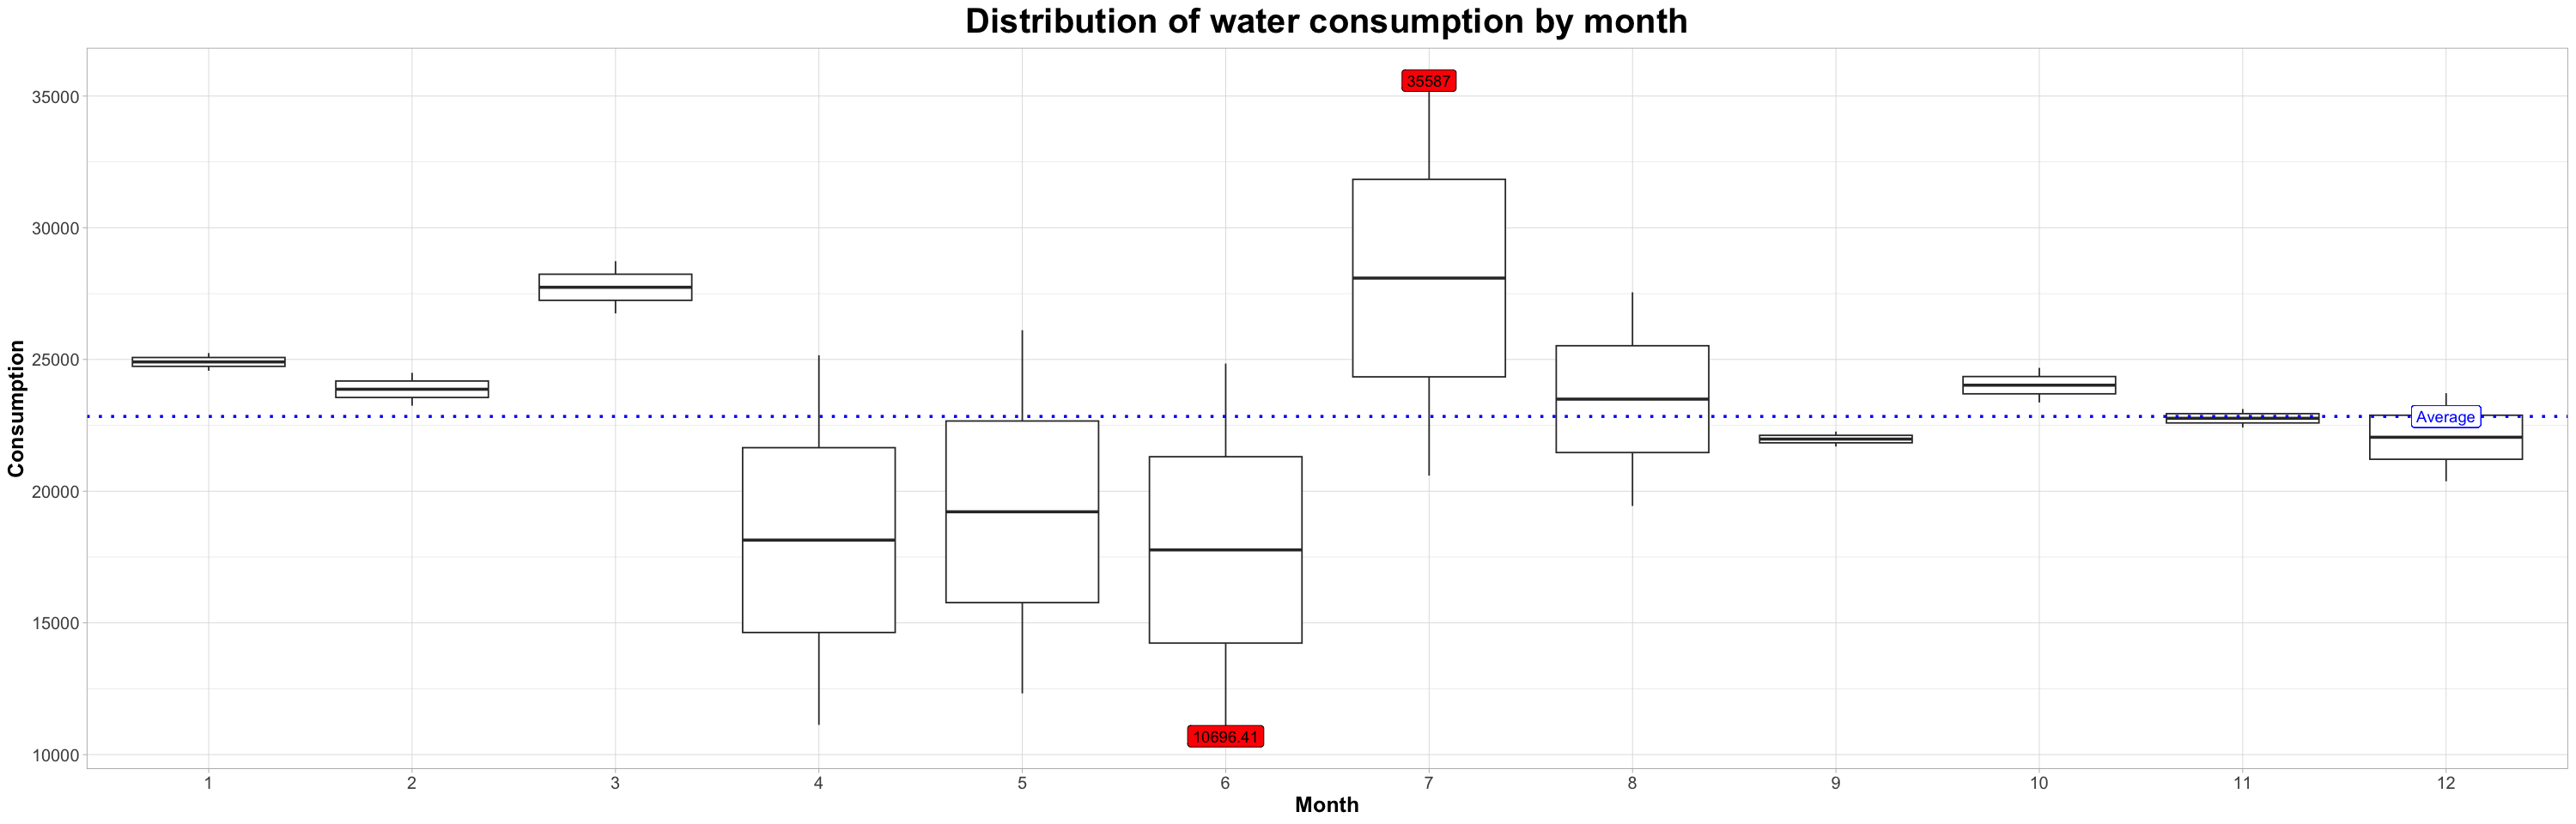

In [57]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_month +
    geom_boxplot(aes(x = factor(month))) +
    base_hline_avg_month +
    geom_label(label = "Average", x = 12, y = avg_month_consumption, color = "blue") +
    geom_label(data = ConsMonthDF %>% filter(is_outlier), aes(label = consumption), color = "black", fill = "red") +
    labs(x = "Month", y = "Consumption") +
    base_title_month + 
    base_theme_month

#### Plot 8: Line plot - Consumption by year and month

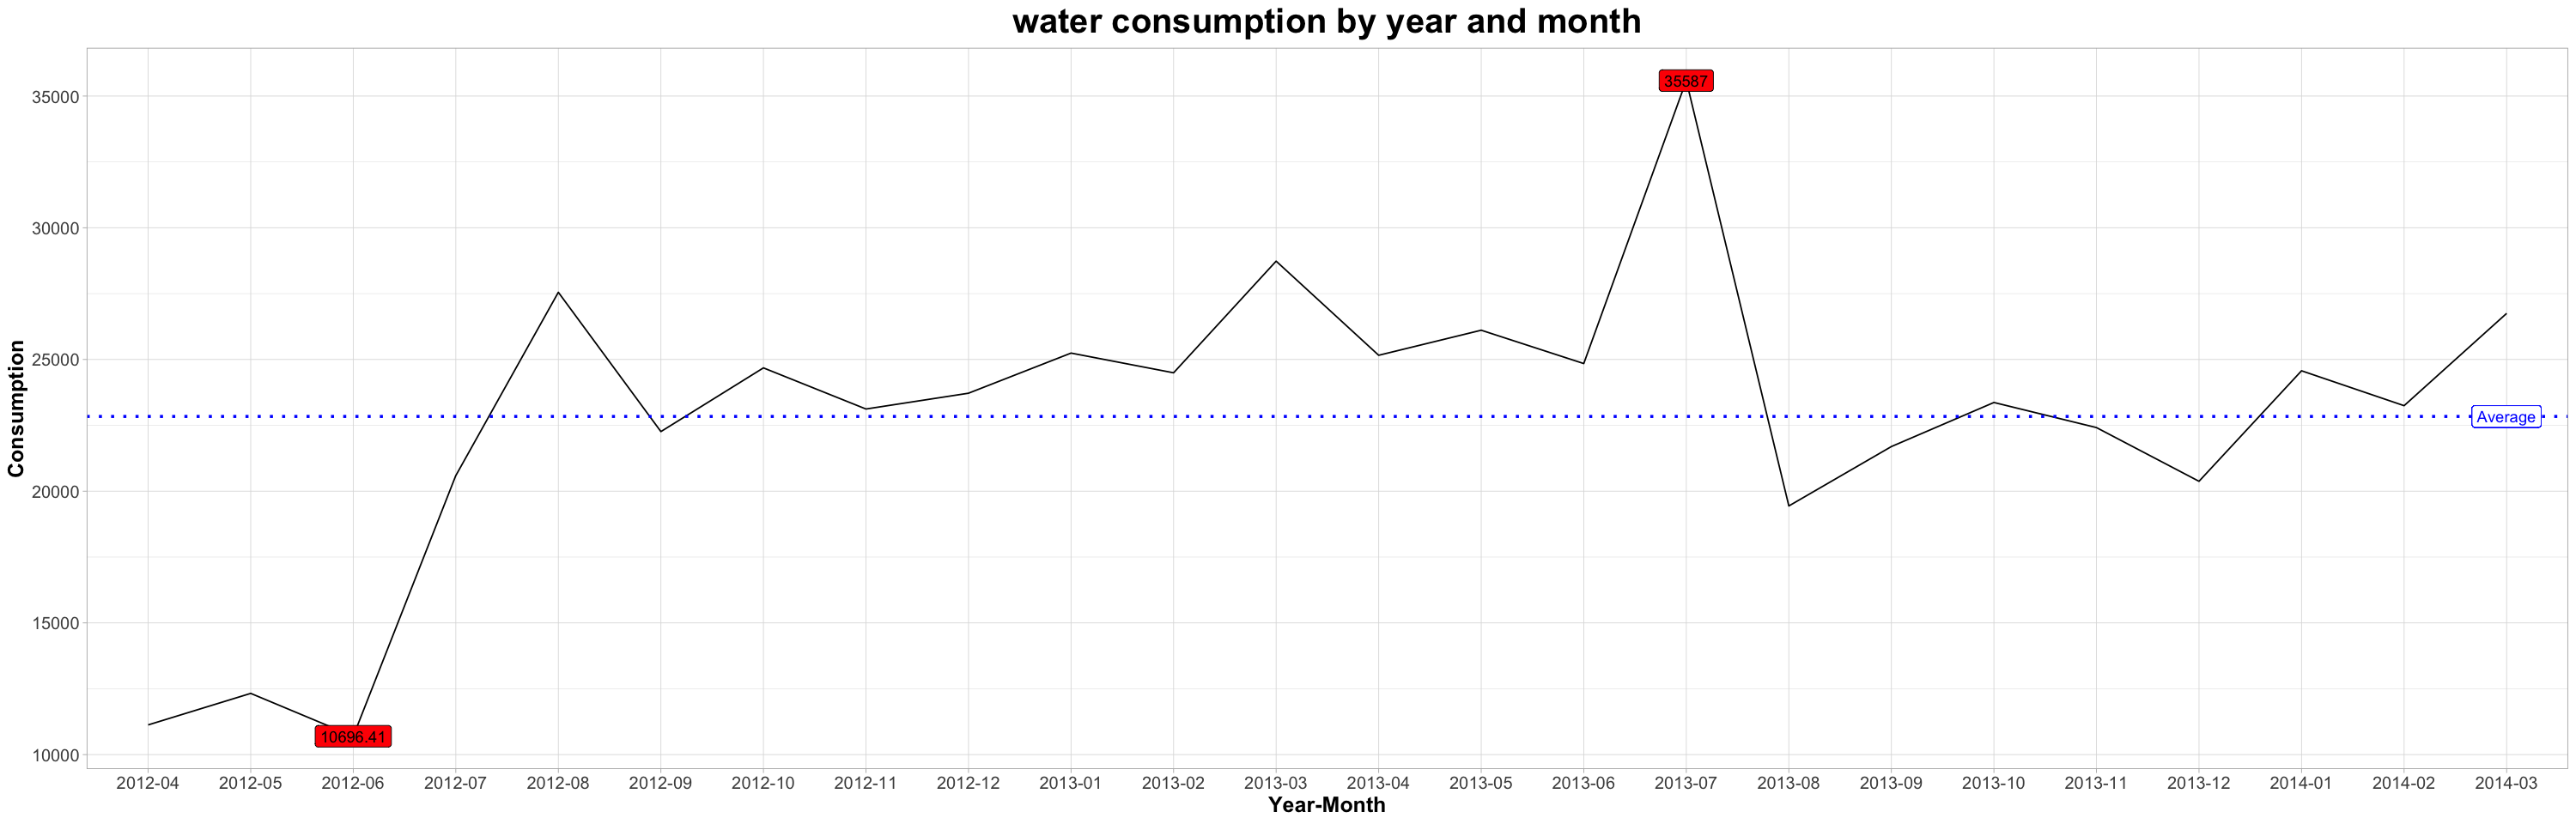

In [58]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define line plot
base_plt_month +
    geom_line(aes(x = factor(year_month), group = 1)) +
    base_hline_avg_month +
    geom_label(label = "Average", x = "2014-03", y = avg_month_consumption, color = "blue", show.legend = TRUE) +
    geom_label(data = ConsMonthDF %>% filter(is_outlier), aes(x = year_month, label = consumption), color = "black", fill = "red") +
    labs(x = "Year-Month", y = "Consumption") +
    ggtitle("water consumption by year and month") + 
    base_theme_month

## 2. Extreme Consumption Periods

##### Prepare Data Frames by adding and selecting necessary columns

In [59]:
# HOUR data: Add necessary columns
ExtremesConsHourDF  <- ConsHourDF %>% 
    filter(is_outlier) %>% 
    mutate( 
        extreme_type = ifelse(consumption == min_hour_consumption, "min", "max"),
        time_frame = "Hour"
    ) %>%
    select(time_frame, year, month, day, hour, consumption, extreme_type)

# DAY data: Add necessary columns
ExtremesConsDayDF   <- ConsDayDF %>% 
    filter(is_outlier) %>% 
    mutate(
        extreme_type = ifelse(consumption == min_day_consumption, "min", "max"),
        hour = as.integer(NA),
        time_frame = "Day"
    ) %>% 
    select(time_frame, year, month, day, hour, consumption, extreme_type)

# Month data: Add necessary columns
ExtremesConsMonthDF <- ConsMonthDF  %>% 
    filter(is_outlier)  %>% 
    mutate(
        extreme_type = ifelse(consumption == min_month_consumption, "min", "max"),
        day = as.integer(NA),
        hour = as.integer(NA),
        time_frame = "Month"
    ) %>% 
    select(time_frame, year, month, day, hour, consumption, extreme_type)

##### Union data and presentation of extreme consumption periods

In [60]:
# Union extreme consumptions of all time frames (month, day, hour)
ExtremesDF <- ExtremesConsHourDF %>% union(ExtremesConsDayDF) %>% union(ExtremesConsMonthDF)
# Display extremes consumption by date
ExtremesDF %>% 
    pivot_wider(names_from = extreme_type, values_from = consumption) %>%
    rename(`Time Frame` = time_frame, Year = year, Month = month, Day = day, Hour = hour, `Minimal Consumption` = min, `Maximal Consumption` = max)

Time Frame,Year,Month,Day,Hour,Minimal Consumption,Maximal Consumption
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hour,2012,4,1,16,0,NA
Hour,2012,4,1,17,0,NA
Hour,2012,4,1,18,0,NA
Hour,2012,4,1,20,0,NA
Hour,2012,4,1,21,0,NA
Hour,2012,4,2,15,0,NA
Hour,2012,4,2,16,0,NA
Hour,2012,4,2,17,0,NA
Hour,2012,4,2,18,0,NA


## 3. Correlations between variables:

### a) Correlation: Consumption vs. Date and Time

##### Calculate and display correlation results

In [61]:
# Three time frames: hour, day, month
hour_consumption_cor    <- cor(ConsHourDF$hour,     ConsHourDF$consumption)
day_consumption_cor     <- cor(ConsDayDF$day,       ConsDayDF$consumption)
month_consumption_cor   <- cor(ConsMonthDF$month,   ConsMonthDF$consumption)

print(paste0("Hour  vs. Consumption correlation: ", round(hour_consumption_cor, 2)))
print(paste0("Day   vs. Consumption correlation: ", round(day_consumption_cor,2)))
print(paste0("Month vs. Consumption correlation: ", round(month_consumption_cor, 2)))

[1] "Hour  vs. Consumption correlation: -0.15"
[1] "Day   vs. Consumption correlation: 0.06"
[1] "Month vs. Consumption correlation: -0.06"


### b) Correlation between weather and consumption

##### Read CSV data from gold weather file

In [62]:
weatherHourDF <- read_csv("../../../curated/weather/gold_hourly_weather.csv", show_col_types = FALSE)
weatherDayDF <- read_csv("../../../curated/weather/gold_daily_weather.csv", show_col_types = FALSE)
weatherMonthDF <- read_csv("../../../curated/weather/gold_monthly_weather.csv", show_col_types = FALSE) %>%
    mutate(year_month = factor(paste(year, month, sep = "-")))

##### Prepare Data Frames by joining weather and consumption data

In [63]:
# HOUR data
WeatherConsHourDF <- weatherHourDF %>%
    inner_join(ConsHourDF,   by = c("year", "month", "day", "hour"), suffix = c("", "_cons")) %>%
    select(year, month,day, hour, avg_temp, avg_dewpt_temp, avg_rel_hum_pct, avg_wind_dir, avg_wind_spd, avg_visib, avg_stn_press, avg_hmdx, avg_wind_chill, consumption)
# DAY data
WeatherConsDayDF <- weatherDayDF %>%
    inner_join(ConsDayDF,   by = c("year", "month", "day"), suffix = c("", "_cons")) %>%
    select(year, month, day, avg_temp, avg_dewpt_temp, avg_rel_hum_pct, avg_wind_dir, avg_wind_spd, avg_visib, avg_stn_press, avg_hmdx, avg_wind_chill, consumption)
# MONTH data
WeatherConsMonthDF <- weatherMonthDF %>%
    inner_join(ConsMonthDF,   by = c("year", "month"), suffix = c("", "_cons")) %>%
    select(year, month, year_month, avg_temp, avg_dewpt_temp, avg_rel_hum_pct, avg_wind_dir, avg_wind_spd, avg_visib, avg_stn_press, avg_hmdx, avg_wind_chill, consumption)

##### Calculate correlation between weather and consumption

In [64]:
# Define correlation Data Frames
# HOUR
WeatherConsHourCorrDF   <- weather_consumption_correlation(WeatherConsHourDF, "Hourly")
# DAY
WeatherConsDayCorrDF    <- weather_consumption_correlation(WeatherConsDayDF, "Daily")
# MONTH
WeatherConsMonthCorrDF  <- weather_consumption_correlation(WeatherConsMonthDF, "Monthly")

##### Display and compare correlations

In [65]:
GlobalWeatherConsCorrDF <- WeatherConsHourCorrDF %>% union(WeatherConsDayCorrDF) %>% union(WeatherConsMonthCorrDF)
GlobalWeatherConsCorrDF %>% 
    pivot_wider(names_from = time_frame, values_from = correlation)

variable_one,variable_two,Hourly,Daily,Monthly
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Consumption,Average Temperature,0.002,-0.003,-0.004
Consumption,Average Dew Point,0.019,0.054,0.093
Consumption,Average Relative Humidity (%),0.029,0.135,0.283
Consumption,Average Wind Direction,0.003,0.000,0.075
Consumption,Average Wind Speed,0.054,0.034,0.068
Consumption,Average Visibility,-0.007,0.006,0.073
Consumption,Average Station Pressure,0.022,-0.019,0.110
Consumption,Average Humidex,-0.015,0.093,0.311
Consumption,Average Wind Chill,0.000,0.024,0.076
